# Kinetic Theory: Evolution from Non-Equilibrium

In this Julia Notebook, we set up a Kinetic Theory problem with an initial non-equilibrium state and evolve it according to the Boltzmann Equation using a Direct Monte-Carlo (DMC) method. The basic structure of this  will be as follows: We will start by setting up the initial state of our system of $N = 1024$ particles and assigning them velocities from a non-equilibrium distribution function. Then, we will start considering the temporal evolution of our system by simulating pairwise collisions, which we will do by defining an evolution function for $v$. Finally, we will also need to measure some properties (namely, $\langle v^2\rangle$, $\langle v^4\rangle$ and $H$), which we will calculate at each step of the simulation to find a temporal series for them.

---------

## Velocity Sampling
We will start this notebook at the beginning: To do anything, we need to sample from the velocities. We start by defining a lot of functions, which will either be immediately useful or necessary for the next sections.
- $SphereSample(r)$ -> This function samples from a the surface of a Sphere with radius $r$. This is one of the ways we can sample our velocities from, but is also useful in defining a unit vector in a random direction, which we will need for our *collisions* section;
- $Sample(r,type)$ -> A function that, given an amplitude $r$ and a type, that can either be "delta" sampling, where our velocity magnitude is perfectly defined and localized, or a uniform sampling, where the velocities themselves are distributed uniformly 
- $AverageVel(v)$ -> Given the array of velocities $v$, this function computes the average velocities in the $x$, $y$ and $z$ directions and outputs it as a vector $[\bar v_x,\bar v_y,\bar v_z]$. We need this mainly to make sure the system doesn't have any initial velocities and enforce the conservation of momentum in the next function;
- $ConserveMom(v)$ -> A very simple function that given a velocity array $v$ ensures that it has 0 average (vector) velocity;
- $AbsoluteVel(v)$ -> Given a velocity array $v$, computes the value of the absolute value of the velocity of each particle, defined as $|\vec v| = \sqrt{v_x^2+v_y^2+v_z^2}$

#### A little aside: Sampling from the Sphere
We mentioned in passing that $SphereSample(r)$ samples from a sphere of radius $r$. Naively, one might assume that this would imply getting a radius and finding two random angles $\theta \in (0,\pi]$ and $\phi \in (0,2\pi]$ and converting from spherical to Cartesian but, alas, it is not the case. This naive assumption would lead to overdense regions near the poles. To sketch a proof of what it should look like instead, we should write the invariant measure element of the probability distribution function:

$$p(x,y,z)d\Omega = p(x,y,z) \sin\theta d\theta d\phi, $$

Where we have written the area element already considering $r$ to be a constant. However, since we are uniformly sampling, $p(x,y,z) \sim 1$ within its finite support, which in turn means we are looking at, essentially:

$$d\cos\theta d\phi$$

Finally, this implies that we need to sample uniformly from the support of $\phi$ and $\cos\theta$, *i.e.*:

$$\phi \sim U(0,2\pi)$$
$$\cos\theta \sim U(-1,1)$$

If we consider $u,v \sim U(0,1)$, this means we must sample them as:

$$\phi = 2\pi u$$
$$\theta = \cos^{-1}(2v-1)$$

And this is exactly what we do in the code (and, after, we do a coordinate transform to go back to cartesian coordinates)

In [173]:
using LinearAlgebra
using Plots
using Statistics
using StatsBase
using QuadGK
function SphereSample(r)
    ϕ = 2π*rand() #ϕ = U(0,2π)
    θ = acos(2*rand()-1) #cosθ = U(-1,1)
    vx = r*sin(θ)*cos(ϕ) #Velocity x
    vy = r*sin(θ)*sin(ϕ) #Velocity y
    vz = r*cos(θ) #Velocity z
    return [vx, vy, vz]
end

function Sample(r,type)#Inputs are a Radius of sampling and the type of sampling we want: Either a 'delta' sampling defined in SphereSample or a uniform sampling
    if type == "delta"
        return SphereSample(r)
    elseif type == "uniform"
        return [r*(2*rand()-1), r*(2*rand()-1), r*(2*rand()-1)]
    end
end

function AverageVel(v)#Returns the average velocity vector of a given velocity distribution
    return [mean(v[:,1]),mean(v[:,2]),mean(v[:,3])]
end

ConserveMom(v) = transpose(transpose(v) .- AverageVel(v))#Enforces conservation of momentum

function AbsoluteVelocity(v)
    return sqrt.(v[:,1].^2 + v[:,2].^2 + v[:,3].^2)
end

AbsoluteVelocity (generic function with 1 method)

### The actual sampling
Here, we finally define all the values we will use for our simulation: $N$, the number of particles, $v_t$, th velocity we use in our sampling. With that, we sample the velocities using the functions we had previously defined. Finally, we use $\langle v^2 \rangle$, which we know from our theoretical analysis should be constant, to define the Maxwell-Boltzmann equilibrium distribution so we can later compare that with the histograms we get in the next sections

In [174]:
N = 1024 # Number of particles
vt = 2.5 #Average Velocity
v = zeros(N,3) #Velocities, unnitialized 
#Now, we start to sample the velocities. For this, we will set them to have constant speed and random directions
for i in 1:N
    v[i,1],v[i,2],v[i,3] = Sample(vt,"delta")
end
v = ConserveMom(v)
#Average velocity in module
T = mean(AbsoluteVelocity(v).^2)/3 #Temperature
a = √(T)
MaxwellBoltzmann(v,a=a) = sqrt(2/π)*v^2/a^3*exp(-v^2/(2a^2)) #Maxwell-Boltzmann distribution

MaxwellBoltzmann (generic function with 2 methods)

-------

## Collisions
The basic idea here is that we want to define an evolution function for our system. It's basic structure will be something like this:
  - Select two random particles, $i$ and $j$
  - Sample a random direction unit vector, $\hat \sigma$
  - Calculate the relative velocity of those particles, $\vec v_{ij} = \vec v_i - \vec v_j$
  - Update the velocities as:
$$\vec v_i^* = \vec v_i - (\vec v_{ij} \cdot \hat \sigma)\hat \sigma$$
$$\vec v_j^* = \vec v_j + (\vec v_{ij} \cdot \hat \sigma)\hat \sigma$$
  - Do this a number of times proportional to the number of particles

The dot products in the update equations essentially encodes the "strength" of the collision, that is, how much the velocities are aligned in the direction of the collision, such that, for example, if $\hat \sigma$ and $v_{ij}$ are perpendicular, the update doesn't actually change anything. This procedure is exactly what we define here as $Evolve(v,steps)$. 

Finally, for the next section, the only *tricky* variable to calculate is $H$, since we don't have an obvious way of calculating it from the sample itself, only the distribution, which we don't have a priori. The basic strategy we employed in calculating it was:
  - Make a histogram out of the sample, which we do by using a function from the StatsBase package, fit
  - From that, calculate the $H$-function as its discretized version, *i.e.* $H=\sum f_i \ln f_i$, paying some special attention to when $f_i=0$ in a bin: In those points, we just consider $f_i \ln f_i = 0$.
(As a minor sidenote, the $H$-function is indeed the Shannon Entropy of the system with changed signs, so usual considerations of entropy should still all work here.)

In [175]:
#We start calulating the effects of collisions by DMC
#We will use a simple model of elastic collisions, where the velocities are just exchanged
function Evolve(v,steps=1)
    for i in 1:steps*N
        p1 = rand(1:N) #Random particle 1
        p2 = rand(1:N) #Random particle 2
        σ = SphereSample(1.0) #Random direction
        vrel = v[p1,:] - v[p2,:] #Relative velocity
        v[p1,:] = v[p1,:] - (vrel⋅σ)*σ #Update velocity 1
        v[p2,:] = v[p2,:] + (vrel⋅σ)*σ #Update velocity 2
    end
    return v
end
function EntropyCalc(vmod,bins=15)
    Hist = fit(Histogram,vmod,range(0,6,bins)).weights/N
    Entropy = 0
    for i=1:bins-1
        if Hist[i] != 0
            Entropy = Hist[i]*log(Hist[i])
        else 
            Entropy = 0
        end
    end
    return Entropy
end


EntropyCalc (generic function with 2 methods)

## Data Acquisition and Representation
Now that we have a way of evolving our system, we want to be able to measure things from it. These will be the $\langle v^2\rangle$,$\langle v^4\rangle$,$\langle v^6\rangle$ and $H$. We'll be evolving them over time, but there is a caveat here: As we shall see briefly, following only one *chain* of this evolution will leave us with very noisy results, and our desired convergences may not be so obvious. How do we remedy this? We essentially evolve $N_c$ different *chains* starting from the same initial state, compute all quantities of interest and then average them out. This leaves us with measurements with significantly less noise. The following cell contains a lot of initializing variables (think of this in the same way one would declare variables at the start of the program in Fortran) and then straightforward computation for the chains  

In [176]:
#----------------------------------------------------------------------------------------#
### Initializing all the different matrices and parameters for this section
tf=100
chains = 40
v²chain = zeros(tf,chains)
v⁴chain = zeros(tf,chains)
v⁶chain=zeros(tf,chains)
Hchain = zeros(tf,chains)
vmodchain = zeros(N,tf,chains)
vmodt = zeros(tf,N)
v² = zeros(tf)
v⁴ = zeros(tf)
v⁶ = zeros(tf)
H = zeros(tf)
#----------------------------------------------------------------------------------------#
vinit = copy(v) #This initializes the initial velocity setting, so we can reuse it every new chain
for j in 1:chains #Loops over the chains
    v = copy(vinit) #This sets the velocity back to the initial state
    for i in 1:tf #Loops over time/steps
        vmod = AbsoluteVelocity(v) #Calculates the absolute velocity
        vmodchain[:,i,j] = vmod #Saves the absolute velocity for the histogram
        v²chain[i,j]=mean(vmod.^2) #Calculates the second moment
        v⁴chain[i,j]=mean(vmod.^4) #Calculates the fourth moment
        v⁶chain[i,j]=mean(vmod.^6) #Calculates the sixth moment
        Hchain[i,j]=EntropyCalc(vmod,10) #Calculates the entropy/H-function
        Evolve(v) #Evolves the system
    end
end
#Now we take the averages of the chains
for i in 1:tf
    v²[i] = mean(v²chain[i,:])
    v⁴[i] = mean(v⁴chain[i,:])
    v⁶[i] = mean(v⁶chain[i,:])
    H[i] = mean(Hchain[i,:])
    #= for j in 1:N
        vmodt[i,j] = mean(vmodchain[j,i,:])
    end =#
end


## Representation 
Finally, we represent several things here: For the sake of illustration, we plot both the results of a single chain and the averaged one, as it is very possible to see the difference in resolution and noise there, but other than that, this just uses very standard tools for everything.

┌ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\BoltzmannNoneq\Velocity.gif
└ @ Plots C:\Users\batti\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\BoltzmannNoneq\\Velocity.gif")
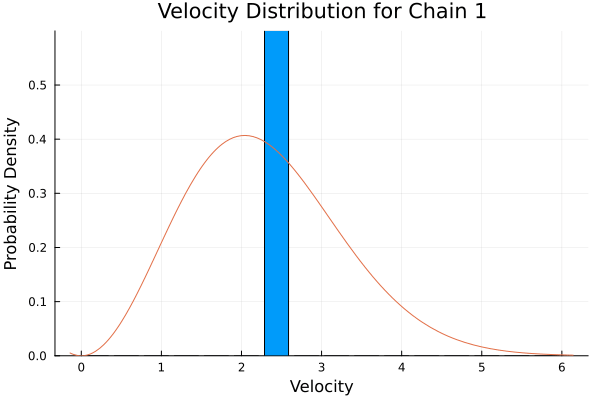

In [177]:
anim = @animate for i in 1:tf
    Histogrammable = fit(Histogram,vmodchain[:,i,1],range(0,6,17)).weights/(6/17*N) #This gives us the histogram that we can plot as a bar graph
    plot(range(0,6,17),Histogrammable,seriestype=:bar,normalize=:pdf,label="",ylim=(0,0.6),title="Velocity Distribution for Chain 1",xlabel="Velocity(m/s)",ylabel="Probability Density",legend=false)
    plot!(MaxwellBoltzmann,label="Maxwell-Boltzmann")
end
gif(anim,"Results/Velocity.gif",fps=1)

┌ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\BoltzmannNoneq\Velocity_Averaged.gif
└ @ Plots C:\Users\batti\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\BoltzmannNoneq\\Velocity_Averaged.gif")
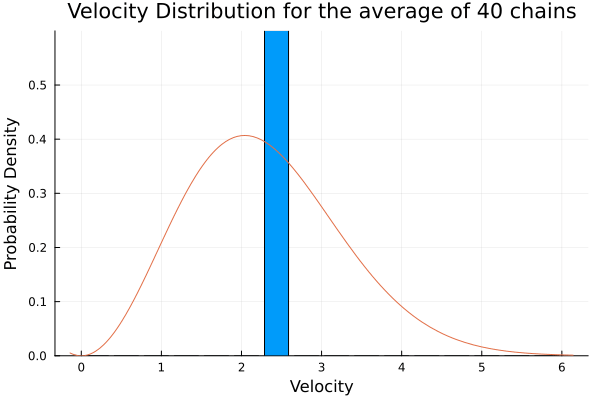

In [178]:
anim = @animate for i in 1:tf
    Histogrammable = zeros(16)
    for j in 1:chains
        Histogrammable = Histogrammable + fit(Histogram,vmodchain[:,i,j],range(0,6,17)).weights/(6/17*N)
    end
    Histogrammable = Histogrammable/chains
    plot(range(0,6,17),Histogrammable,seriestype=:bar,normalize=:pdf,label="",ylim=(0,0.6),title="Velocity Distribution for the average of 40 chains",xlabel="Velocity",ylabel="Probability Density",legend=false)
    plot!(MaxwellBoltzmann,label="Maxwell-Boltzmann")
end
gif(anim,"Results/Velocity_Averaged.gif",fps=1)

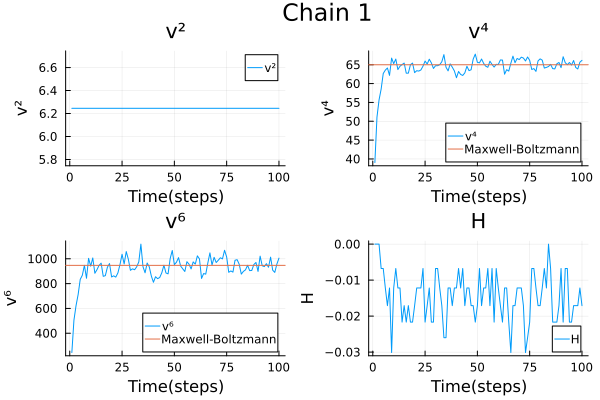

In [179]:
function PlotIthChain(i)
    p1 = plot(v²chain[:,i],label="v²",xlabel="Time(steps)",ylabel="v²",title="v²",yrange=(mean(v²)-0.5,mean(v²)+0.5))
    p2 = plot(v⁴chain[:,i],label="v⁴",xlabel="Time(steps)",ylabel="v⁴",title="v⁴")
    hline!([quadgk(v->v^4*MaxwellBoltzmann(v),0,Inf)[1]],label="Maxwell-Boltzmann")
    p3 = plot(v⁶chain[:,i],label="v⁶",xlabel="Time(steps)",ylabel="v⁶",title="v⁶")
    hline!([quadgk(v->v^6*MaxwellBoltzmann(v),0,Inf)[1]],label="Maxwell-Boltzmann")
    p4 = plot(Hchain[:,i],label="H",xlabel="Time(steps)",ylabel="H",title="H")
    plot(p1,p2,p3,p4, plot_title="Chain "*string(i))
    savefig("Results/Moments_chain"*string(i)*".png")
    plot(p1,p2,p3,p4, plot_title="Chain "*string(i))
end
PlotIthChain(1)


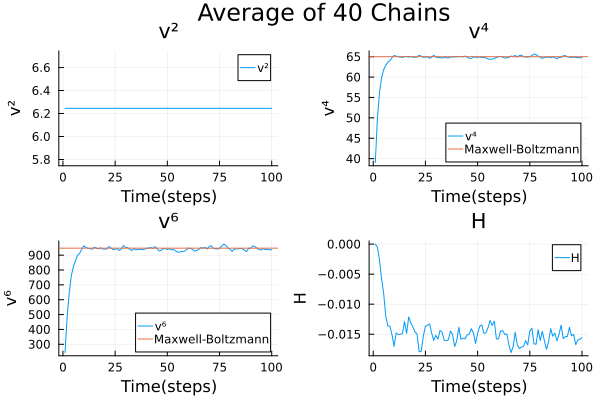

In [180]:
p1 = plot(v²,label="v²",xlabel="Time(steps)",ylabel="v²",title="v²",yrange=(mean(v²)-0.5,mean(v²)+0.5))
p2 = plot(v⁴,label="v⁴",xlabel="Time(steps)",ylabel="v⁴",title="v⁴")
hline!([quadgk(v->v^4*MaxwellBoltzmann(v),0,Inf)[1]],label="Maxwell-Boltzmann")
p3 = plot(v⁶,label="v⁶",xlabel="Time(steps)",ylabel="v⁶",title="v⁶")
hline!([quadgk(v->v^6*MaxwellBoltzmann(v),0,Inf)[1]],label="Maxwell-Boltzmann")
p4 = plot(H,label="H",xlabel="Time(steps)",ylabel="H",title="H")
plot(p1,p2,p3,p4, plot_title="Average of 40 Chains")
savefig("Results/Moments_averaged.png")
plot(p1,p2,p3,p4, plot_title="Average of 40 Chains")